# Create a domain-specific AI chatbot.

This notebook follows a tutorial provided by Open AI (found [here](https://platform.openai.com/docs/tutorials/web-qa-embeddings)).

At a high level, we are using scrapy to scrap select pages from focusedlabs.io, then using that data to populate a vector database.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
!{sys.executable} -m pip install -r ../requirements.txt

## Scrape focusedlabs.io
Run a scrapy spider. You should see a json file appear in web-scrape-data.

In [13]:
!{sys.executable} -m scrapy runspider focusedlabs_home_spider.py -o data/focusedlabs-home.jsonl
!{sys.executable} -m scrapy runspider focusedlabs_about_spider.py -o data/focusedlabs-about.jsonl
!{sys.executable} -m scrapy runspider focusedlabs_contact_spider.py -o data/focusedlabs-contact.jsonl
!{sys.executable} -m scrapy runspider focusedlabs_case_studies_spider.py -o data/focusedlabs-case-studies.jsonl

2023-06-20 09:30:58 [scrapy.utils.log] INFO: Scrapy 2.9.0 started (bot: scrapybot)
2023-06-20 09:30:58 [scrapy.utils.log] INFO: Versions: lxml 4.9.2.0, libxml2 2.9.13, cssselect 1.2.0, parsel 1.8.1, w3lib 2.1.1, Twisted 22.10.0, Python 3.11.3 (main, Apr  7 2023, 20:13:31) [Clang 14.0.0 (clang-1400.0.29.202)], pyOpenSSL 23.2.0 (OpenSSL 3.1.1 30 May 2023), cryptography 41.0.0, Platform macOS-13.4-arm64-arm-64bit
2023-06-20 09:30:58 [scrapy.crawler] INFO: Overridden settings:
{'SPIDER_LOADER_WARN_ONLY': True}
2023-06-20 09:30:58 [py.warnings] WARNING: /opt/homebrew/lib/python3.11/site-packages/scrapy/utils/request.py:232: ScrapyDeprecationWarning: '2.6' is a deprecated value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting.

It is also the default value. In other words, it is normal to get this warning if you have not defined a value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting. This is so for backward compatibility reasons, but it will change in a future version of Scrapy

## Setup

First we'll setup our libraries and environment variables

In [14]:
import openai
import os
import requests
import numpy as np
import pandas as pd
from typing import Iterator
import tiktoken
import textract
from numpy import array, average

from database import get_redis_connection

# Set our default models and chunking size
from config import COMPLETIONS_MODEL, EMBEDDINGS_MODEL, CHAT_MODEL, TEXT_EMBEDDING_CHUNK_SIZE, VECTOR_FIELD_NAME

# Ignore unclosed SSL socket warnings - optional in case you get these errors
import warnings

warnings.filterwarnings(action="ignore", message="unclosed", category=ImportWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [15]:
pd.set_option('display.max_colwidth', 0)

## Storage

We're going to use Redis as our database for both document contents and the vector embeddings. You will need the full Redis Stack to enable use of Redisearch, which is the module that allows semantic search - more detail is in the [docs for Redis Stack](https://redis.io/docs/stack/get-started/install/docker/).

To set this up locally, you will need to install Docker and then run the following command: ```docker run -d --name redis-stack -p 6379:6379 -p 8001:8001 redis/redis-stack:latest```.

The code used here draws heavily on [this repo](https://github.com/RedisAI/vecsim-demo).

After setting up the Docker instance of Redis Stack, you can follow the below instructions to initiate a Redis connection and create a Hierarchical Navigable Small World (HNSW) index for semantic search.

In [16]:
# Setup Redis
from redis import Redis
from redis.commands.search.query import Query
from redis.commands.search.field import (
    TextField,
    VectorField,
    NumericField
)
from redis.commands.search.indexDefinition import (
    IndexDefinition,
    IndexType
)

redis_client = get_redis_connection()

In [17]:
# Constants
VECTOR_DIM = 1536 #len(data['title_vector'][0]) # length of the vectors
#VECTOR_NUMBER = len(data)                 # initial number of vectors
PREFIX = "focusedlabsdoc"                            # prefix for the document keys
DISTANCE_METRIC = "COSINE"                # distance metric for the vectors (ex. COSINE, IP, L2)

In [18]:
# Create search index

# Index
INDEX_NAME = "fl-index"           # name of the search index
VECTOR_FIELD_NAME = 'content_vector'

# Define RediSearch fields for each of the columns in the dataset
# This is where you should add any additional metadata you want to capture
filename = TextField("filename")
text_chunk = TextField("text_chunk")
file_chunk_index = NumericField("file_chunk_index")

# define RediSearch vector fields to use HNSW index

text_embedding = VectorField(VECTOR_FIELD_NAME,
    "HNSW", {
        "TYPE": "FLOAT32",
        "DIM": VECTOR_DIM,
        "DISTANCE_METRIC": DISTANCE_METRIC
    }
)
# Add all our field objects to a list to be created as an index
fields = [filename,text_chunk,file_chunk_index,text_embedding]

In [19]:
redis_client.ping()
# Optional to clean db
# redis_client.flushdb()

True

In [27]:
# Optional step to drop the index if it already exists
redis_client.ft(INDEX_NAME).dropindex()

# Check if index exists
try:
    redis_client.ft(INDEX_NAME).info()
    print("Index already exists")
except Exception as e:
    print(e)
    # Create RediSearch Index
    print('Not there yet. Creating')
    redis_client.ft(INDEX_NAME).create_index(
        fields = fields,
        definition = IndexDefinition(prefix=[PREFIX], index_type=IndexType.HASH)
    )

Unknown Index name
Not there yet. Creating


## Web Text File Ingestion
- Save cleaned text to a csv file
- Tokenize text


In [21]:
import pandas as pd
from transformers import normalize_text

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("data/"):

    # Open the file and read the text
    with open("data/" + file, "r", encoding="UTF-8") as f:
        text = f.read()
        cleaned_text = normalize_text(text)

        texts.append((file.replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
# df['text'] = df.fname
df.to_csv('all-clean-scraped.csv')
df.head()

fname  \
0  focusedlabs contact.jsonl        
1  focusedlabs home.jsonl           
2  focusedlabs case studies.jsonl   
3  focusedlabs about.jsonl          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

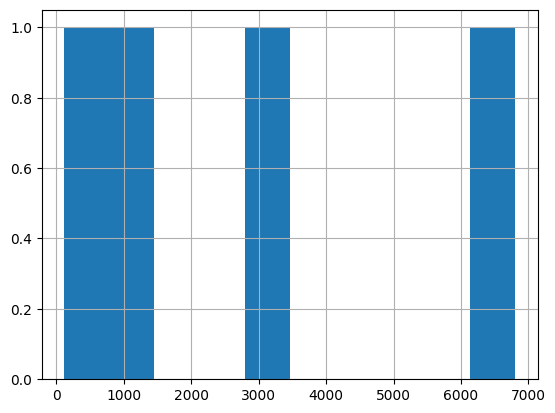

In [22]:
import tiktoken
import matplotlib.pyplot as plt

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('all-clean-scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()
plt.show()

<Axes: >

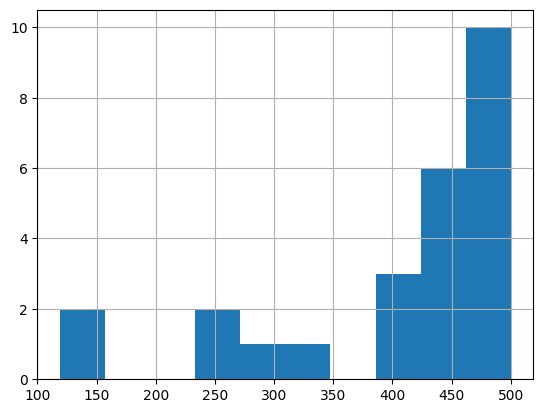

In [23]:
from alt_transformers import process_dataframe

df = process_dataframe(df, tokenizer)
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [24]:
import openai
from config import OPENAI_API_KEY
openai.api_key = OPENAI_API_KEY

df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

df.to_csv('embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,"{""h2"": ""We're here to help""}\n{""p"": ""Focused Labs helps your team build and deliver the right product and the agile, versatile technology culture you need to keep it going after we leave.""}\n{""p"": ""433 W Van Buren StSuite 1100-BChicago, IL 60607""}\n{""p"": ""433 W Van Buren St\nSuite 1100-B\nChicago, IL 60607\n(708) 303-8088""}\n{""p"": ""\u00a9 2022 Focused Labs, All Rights Reserved.""}\n",119,"[-0.01904459111392498, 0.03407673165202141, 0.008788133040070534, -0.0014456079807132483, -0.012844194658100605, 0.024496285244822502, 0.012575244531035423, -0.011557594873011112, -0.02028030715882778, -0.027200326323509216, 0.011673897504806519, 0.009478681720793247, -0.017387274652719498, 0.010241919197142124, -0.002202484989538789, 0.015555504709482193, 0.011848351918160915, -0.03451287001371384, 0.005586171057075262, -0.013796424493193626, -0.02048383839428425, 0.006491152569651604, -0.00790859293192625, 0.03430933877825737, -0.024598050862550735, -0.014116257429122925, 0.0128732705488801, -0.015410126186907291, -0.020338458940386772, -0.03265202417969704, -0.005044635850936174, -0.006091361399739981, -0.03457101806998253, 0.0011030597379431129, 0.008475570008158684, 0.0015073938993737102, 0.0031728867907077074, -0.0074143060483038425, 0.026720577850937843, -0.023493174463510513, 0.016849374398589134, 0.017154669389128685, -0.0013601981336250901, -0.023594938218593597, -0.02437998354434967, -0.008112123236060143, 0.00460850028321147, -0.00894078053534031, -0.013847307302057743, 0.03381505236029625, 0.012110033072531223, 0.011790200136601925, -0.0033437067177146673, -0.0012720623053610325, -0.0007209867471829057, -0.024801580235362053, 0.010590827092528343, 0.01668945699930191, -0.004928332753479481, -0.009231538511812687, 8.972582872956991e-05, -0.02358040027320385, -0.021312495693564415, 0.0133384820073843, 0.002335143042728305, -0.006004134193062782, 0.004572155419737101, 0.03358244523406029, 0.013636508025228977, -0.010779819451272488, 0.017474502325057983, 0.0028494196012616158, -0.006734661292284727, -0.0030511324293911457, 0.016020717099308968, 0.0018135973950847983, -0.020425686612725258, -0.016645845025777817, 0.003928855527192354, 0.011317720636725426, 0.018477613106369972, -0.01929173432290554, -0.014159871265292168, 0.019829634577035904, 0.011586670763790607, 0.013185834512114525, 0.0017863389803096652, 0.021763170138001442, -0.013883652165532112, -0.006323967128992081, -0.024161916226148605, 0.03523975983262062, -0.011339526623487473, 0.025586625561118126, 0.0052081868052482605, 0.002029848052188754, -0.012880539521574974, 0.019146354869008064, -0.01269154716283083, -0.03369874879717827, ...]"
1,"{""h1"": ""Modern Hospitality: Strengthening Customer Loyalty""}\n{""h1"": ""A digital transformation partner with Focus""}\n{""h2"": ""Build""}\n{""h2"": ""Deploy""}\n{""h2"": ""Learn""}\n{""h2"": ""The unintimidating and unintimidated software experts""}\n{""h2"": ""agile""}\n{""h2"": ""DevOps""}\n{""h2"": ""At scale""}\n{""h2"": ""Turning digital transformation into business results""}\n{""h2"": ""Building a culture of great software in real-time""}\n{""h3"": ""Agile Workflow Enabled Startup BTR Energy to Automate Workflows""}\n{""h3"": """"}\n{""p"": ""Attend our session with the CMO of Lettuce Entertain You at the Restaurant Leadership Conference 2023""}\n{""p"": ""Technology can enable your best ideas. At Focused Labs, we work directly with your team to build the software and processes that streamline delivery and transform the role technology plays in your company.""}\n{""p"": ""We\u2019ll get curious about the problem and work with you to find the best practical solution. We know the pain of software that never launches.""}\n{""p"": ""We continuously deliver software and collect data. The results we produce earn your team\u2019s trust and prove the value of our approach.""}\n{""p"": ""We build the solutions you need now and the DevOps culture to keep your team delivering best-in-

In [25]:
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

df=pd.read_csv('embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()


,text,n_tokens,embeddings
0,"{""h2"": ""We're here to help""}\n{""p"": ""Focused Labs helps your team build and deliver the right product and the agile, versatile technology culture you need to keep it going after we leave.""}\n{""p"": ""433 W Van Buren StSuite 1100-BChicago, IL 60607""}\n{""p"": ""433 W Van Buren St\nSuite 1100-B\nChicago, IL 60607\n(708) 303-8088""}\n{""p"": ""\u00a9 2022 Focused Labs, All Rights Reserved.""}\n",119,"[-0.01904459111392498, 0.03407673165202141, 0.008788133040070534, -0.0014456079807132483, -0.012844194658100605, 0.024496285244822502, 0.012575244531035423, -0.011557594873011112, -0.02028030715882778, -0.027200326323509216, 0.011673897504806519, 0.009478681720793247, -0.017387274652719498, 0.010241919197142124, -0.002202484989538789, 0.015555504709482193, 0.011848351918160915, -0.03451287001371384, 0.005586171057075262, -0.013796424493193626, -0.02048383839428425, 0.006491152569651604, -0.00790859293192625, 0.03430933877825737, -0.024598050862550735, -0.014116257429122925, 0.0128732705488801, -0.015410126186907291, -0.020338458940386772, -0.03265202417969704, -0.005044635850936174, -0.006091361399739981, -0.03457101806998253, 0.0011030597379431129, 0.008475570008158684, 0.0015073938993737102, 0.0031728867907077074, -0.0074143060483038425, 0.026720577850937843, -0.023493174463510513, 0.016849374398589134, 0.017154669389128685, -0.0013601981336250901, -0.023594938218593597, -0.02437998354434967, -0.008112123236060143, 0.00460850028321147, -0.00894078053534031, -0.013847307302057743, 0.03381505236029625, 0.012110033072531223, 0.011790200136601925, -0.0033437067177146673, -0.0012720623053610325, -0.0007209867471829057, -0.024801580235362053, 0.010590827092528343, 0.01668945699930191, -0.004928332753479481, -0.009231538511812687, 8.972582872956991e-05, -0.02358040027320385, -0.021312495693564415, 0.0133384820073843, 0.002335143042728305, -0.006004134193062782, 0.004572155419737101, 0.03358244523406029, 0.013636508025228977, -0.010779819451272488, 0.017474502325057983, 0.0028494196012616158, -0.006734661292284727, -0.0030511324293911457, 0.016020717099308968, 0.0018135973950847983, -0.020425686612725258, -0.016645845025777817, 0.003928855527192354, 0.011317720636725426, 0.018477613106369972, -0.01929173432290554, -0.014159871265292168, 0.019829634577035904, 0.011586670763790607, 0.013185834512114525, 0.0017863389803096652, 0.021763170138001442, -0.013883652165532112, -0.006323967128992081, -0.024161916226148605, 0.03523975983262062, -0.011339526623487473, 0.025586625561118126, 0.0052081868052482605, 0.002029848052188754, -0.012880539521574974, 0.019146354869008064, -0.01269154716283083, -0.03369874879717827, ...]"
1,"{""h1"": ""Modern Hospitality: Strengthening Customer Loyalty""}\n{""h1"": ""A digital transformation partner with Focus""}\n{""h2"": ""Build""}\n{""h2"": ""Deploy""}\n{""h2"": ""Learn""}\n{""h2"": ""The unintimidating and unintimidated software experts""}\n{""h2"": ""agile""}\n{""h2"": ""DevOps""}\n{""h2"": ""At scale""}\n{""h2"": ""Turning digital transformation into business results""}\n{""h2"": ""Building a culture of great software in real-time""}\n{""h3"": ""Agile Workflow Enabled Startup BTR Energy to Automate Workflows""}\n{""h3"": """"}\n{""p"": ""Attend our session with the CMO of Lettuce Entertain You at the Restaurant Leadership Conference 2023""}\n{""p"": ""Technology can enable your best ideas. At Focused Labs, we work directly with your team to build the software and processes that streamline delivery and transform the role technology plays in your company.""}\n{""p"": ""We\u2019ll get curious about the problem and work with you to find the best practical solution. We know the pain of software that never launches.""}\n{""p"": ""We continuously deliver software and collect data. The results we produce earn your team\u2019s trust and prove the value of our approach.""}\n{""p"": ""We build the solutions you need now and the DevOps culture to keep your team delivering best-in-

In [26]:
from rough_chat import answer_question
answer_question(df, question="What are some of the solutions that Focused Labs has created?")


'Focused Labs has created solutions such as automated backend operations, an optimized web experience for clients, and an easier experience when registering for events, accessing digital materials and viewing upcoming programs and events.'